

# Investor Risk Tolerance and Robo advisors

The goal of this case study is to build a machine learning model to predict the risk tolerance or risk aversion of an investor, and use the model in a robo-advisor dashboard.


## Content

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, the predicted variable is the “true” risk tolerance of an individual and the predictor variables are demographic, financial and behavioral attributes of an individual

For this case study the data used is from survey of Consumer Finances which is conducted by the Federal Reserve Board. The data source is : 
https://www.federalreserve.gov/econres/scf_2009p.htm


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
import os
import sys

root_dir = os.path.abspath('../..')
sys.path.append(root_dir)
from functions import run_kfold_analysis, run_grid_search, ParamsKfold, ParamsGridSearch
from case_study_3 import load_data, clean_data, calc_risk_tolerance


In [2]:
# Core libraries 

import copy 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Libraries for Deep Learning Models

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor

# Libraries for Statistical Models
import statsmodels.api as sm

# Libraries for Saving the Model
from pickle import dump, load


2022-10-06 09:53:22.940124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-06 09:53:22.940198: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Disable the warnings

import warnings
warnings.filterwarnings('ignore')


<a id='1.2'></a>
## 2.2. Loading the Data

In [4]:
# # Load dataset

dataset = load_data()

In [5]:
dataset.shape

(19285, 516)

<a id='2'></a>
## 3. Data Preparation and Feature Selection

<a id='2.1'></a>
## 3.1. Preparing the predicted variable

The dataset from "Survey of Consumer Finances" contains the Household's demographics, net worth, financial and non-financial assets for the same demographics in 2007 (pre-crisis) and 2009(post-crisis). 

We prepare the predicted variable, which is the "true" risk tolerance in the following steps. There are different ways of getting the "true" risk tolerance. The idea and the purpose of this case study is to come up with an approach to solve the behavioral finance problem using machine learning. 

The steps to compute the predicted variables are as follows: 

1) Compute the Risky asset and the riskless assets for all the individuals in the survey data. Risky and riskless assets are defined as follows: 
* **Risky assets** is investments in mutual funds, stocks, bonds, commodities, and
real estate, and an estimate of human capital. 
* **Risk Free Assets**: checking and savings balances,certificates of deposit, and other cash balances and equivalents.

2) We take the ratio of risky assets to total assets of an investor and consider that as a measure of risk tolerance of an investor. From the data of SCF, we have the data of risky and riskless assets for the individuals for 2007 and 2009. We use this data and normalise the risky assets with the stock price of 2007 vs. 2009 to get risk tolerance. 

* **Risk Tolerance**  just defined as the ratio of Risky Asset to Riskless Assets normalised with the average S&P500 of 2007 vs 2009. 
Average S&P500 in 2007: 1478
Average S&P500 in 2009: 948

3) In a lot of literature, an intelligent investor is the one who doesn't change its risk tolerance during the change in the market. So, we consider the investors who change their risk tolerance by less than 10% between 2007 and 2009 as the intelligent investors. Of course, this is a qualitative judgement and is subject to change. However, as mentioned before more than being accurate and precise the purpose of theis case study is to demonstrate the usage of the machine learning and provide a machine learning based framework in behavioral finance and portfolio management which can be further leveraged for more detailed analysis.

In [6]:
dataset.head()

,Unnamed: 0,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,...,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
0,0,1,11,11668.134198,47,3,12,2,1,0,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,270.403054,57
1,1,1,12,11823.456494,47,3,12,2,1,0,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,249.593620,57
2,2,1,13,11913.228354,47,3,12,2,1,0,...,-50.000000,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.233358,57
3,3,1,14,11929.394266,47,3,12,2,1,0,...,-33.333333,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.273158,57
4,4,1,15,11917.722907,47,3,12,2,1,0,...,-38.596491,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,232.690767,57


In [7]:
dataset2 = clean_data(dataset)

Let us plot the risk tolerance of 2007 and 2009. 

<AxesSubplot:xlabel='RT07'>

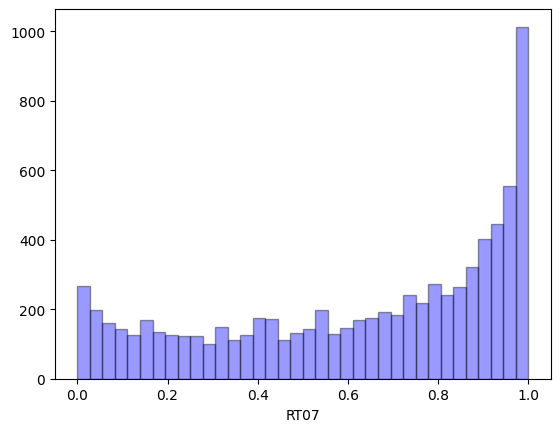

In [8]:
sns.distplot(
    dataset2['RT07'], 
    hist=True, 
    kde=False, 
    bins=int(180 / 5), 
    color='blue',
    hist_kws={'edgecolor':'black'}
)


Looking at the risk tolerance of 2007, we see that a significant number of individuals had risk tolerance close to one, meaning the investment ws more skewed towards the risky assets as compared to the riskless assets. Now let us look at the risk tolerance of 2009.

<AxesSubplot:xlabel='RT09'>

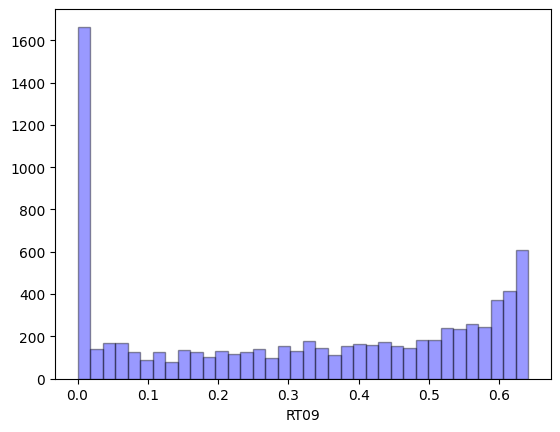

In [9]:
sns.distplot(
    dataset2['RT09'], 
    hist=True, 
    kde=False, 
    bins=int(180 / 5), 
    color='blue',
    hist_kws={'edgecolor':'black'}
)


Clearly, the behavior of the individuals reversed in 2009 after crisis and majority of the investment was in risk free assets. Overall risk tolerance decreased, which is shown by majority of risk tolerance being close to 0 in 2009. 
In the next step we calculate the risk tolerance of 'intelligent investors' (investors whose risk tolerance change between 2007 and 2009 was less than 10%).


In [10]:
dataset3 = calc_risk_tolerance(dataset2)


<a id='2.2'></a>
## 3.2. Feature Selection-Limit the Feature Space 

<a id='2.2.2'></a>
### 3.2.2.  Features elimination

In order to filter the features further we do the following:
1. Check the description in the Data Dictionary (https://www.federalreserve.gov/econres/files/codebk2009p.txt, https://www.federalreserve.gov/econresdata/scf/files/fedstables.macro.txt) and only keep the features that are intuitive. The description is as follows: 


* AGE: There are 6 age categories, where 1 represents age less than 35 and 6 represents age more than 75.
* EDUC: There are 4 education categories, where 1 represents no high school and 4 represents college degree.
* MARRIED: It represents marital status. There are two categories where 1 represents married and 2 represents unmarried. 
* OCCU: It represents occupation category. 1 represents managerial category and 4 represents unemployed.
* KIDS: It represents number of kids. 
* NWCAT: It represents net worth category. There are 5 categories, where 1 net worth less than 25 percentile and 5 represents net worth more than 90th percentile. 
* INCCL: It represents income category. There are 5 categories, where 1 income less than 10,000 and 5 represents net worth more than 100,000
* RISK: It represents the willingness to take risk on a scale of 1 to 4, where 1 represents highest level of willingness to take risk. 

2. Keep only the intuitive factors as of 2007 only and remove all the intermediate features and features related to 2009, as the variables of 2007 are the only ones required for predicting the risk tolerance.


In [11]:
keep_list = [
    'AGE07', 'EDCL07', 'MARRIED07', 'KIDS07', 'OCCAT107', 
    'INCOME07', 'RISK07', 'NETWORTH07', 'TrueRiskTolerance',
]
drop_list = [col for col in dataset3.columns if col not in keep_list]
dataset3 = dataset3.drop(labels=drop_list, axis=1)


Let us look at the correlation among the features.

<AxesSubplot:title={'center':'Correlation Matrix'}>

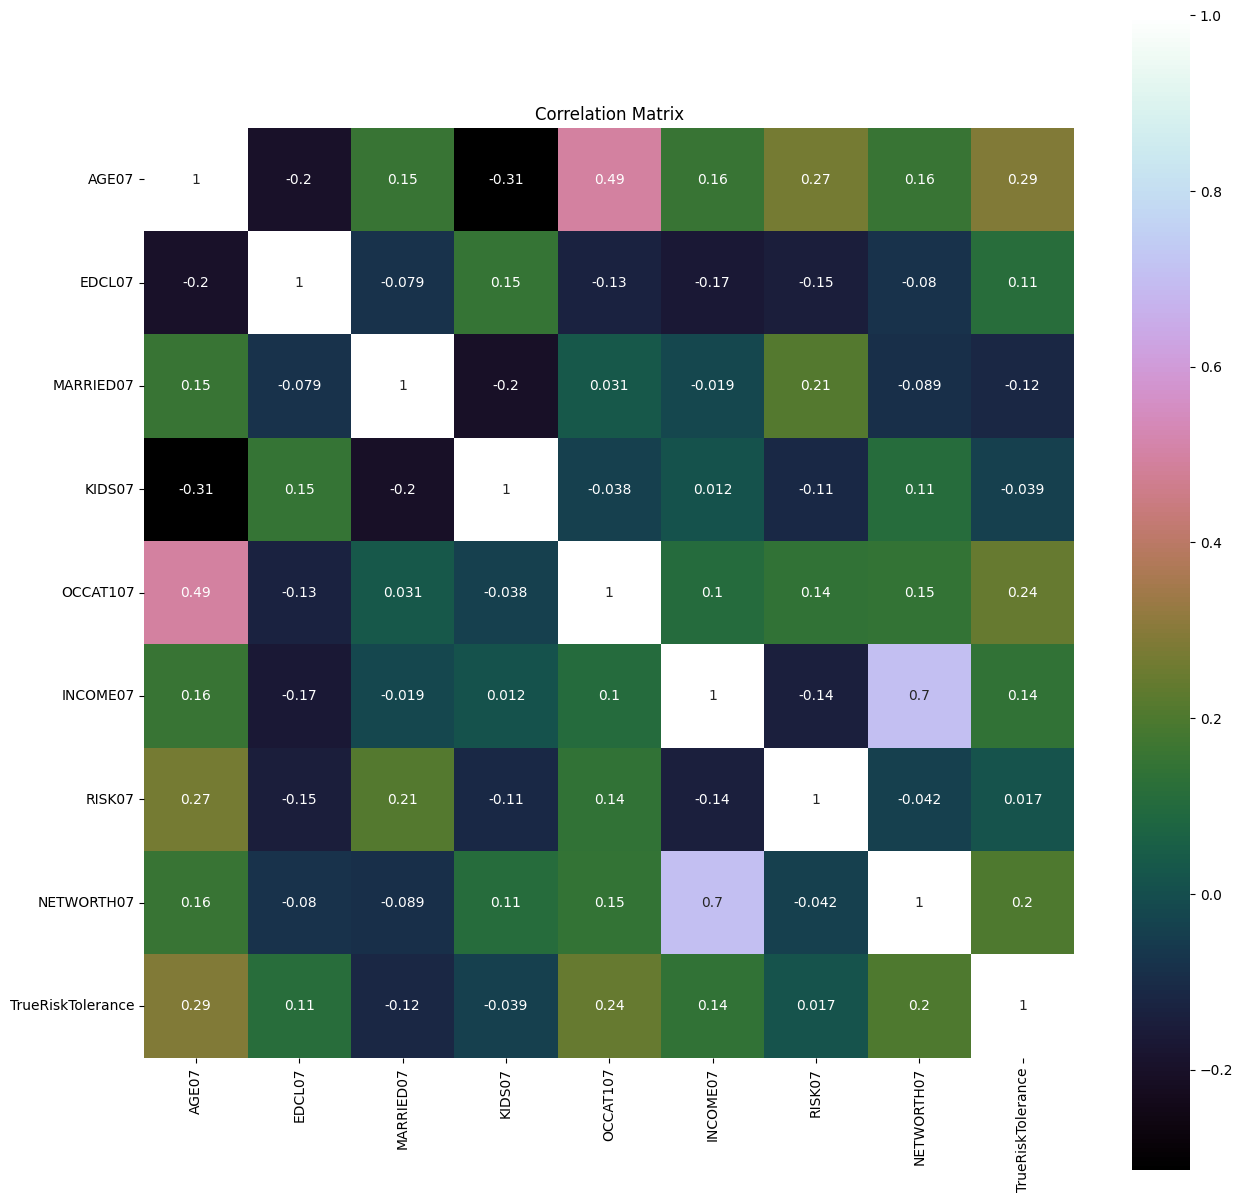

In [12]:
# Correlation

correlation = dataset3.corr()
plt.figure(figsize=(15, 15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')


Looking at the correlation chart above, networth and income are positively correlated with the risk tolerance.
With more number of kids and marriage the risk tolerance decreases. As the willingness to take risk decreases the risk tolerance decreases. With age there is a positive relationship of the risk tolerance. 

As per the paper "Does Risk Tolerance Decrease With Age?(Hui Wang1,Sherman Hanna)", Relative risk aversion decreases as people age (i.e., the proportion of net wealth invested in risky assets increases as people age) when other variables are held constant.Therefore, risk tolerance increases with age. 

So, in summary all the variables and their relationship with risk tolerance seems intuitive. 

<a id='4'></a>
# 4. Evaluate Algorithms and Models

Let us evaluate the algorithms and the models. 

<a id='4.1'></a>
## 4.1. Train Test Split

Performing a train and test split in this step. 

In [13]:
# Split out validation dataset for the end

seed = 3
validation_size = 0.2
Y= dataset3.loc[:, "TrueRiskTolerance"]
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)


<a id='4.2'></a>
## 4.2. Test Options and Evaluation Metrics


<a id='4.3'></a>
## 4.3. Compare Models and Algorithms

### Regression Models

In [14]:
num_folds = 10
scoring = 'r2'
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    ('SVR', SVR()),
    
    # Neural Network
    # ('MLP', MLPRegressor()),
    
    #Ensable Models 
    ('ABR', AdaBoostRegressor()),
    ('GBR', GradientBoostingRegressor()),
    ('RFR', RandomForestRegressor()),
    ('ETR', ExtraTreesRegressor()),
]

params_kfold = ParamsKfold(
    models=models,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=num_folds,
    scoring=scoring,
    seed=seed,
    shuffle=True,
)

### K-folds cross validation

In [15]:
results_kfold = run_kfold_analysis(params_kfold)


LR: -0.102704 (0.179297) 0.026382 0.043532
LASSO: -0.041555 (0.109033) 0.030011 0.055596
EN: -0.047729 (0.108990) 0.029663 0.054448
KNN: -0.424599 (0.141428) 0.010024 0.015660
CART: -0.600998 (0.232621) 0.000000 0.015378
SVR: -0.127821 (0.100887) 0.027916 0.028254
ABR: -0.387116 (0.131950) 0.015654 0.016675
GBR: -0.615730 (0.141280) 0.002660 0.008429
RFR: -0.689587 (0.113250) 0.001325 0.007284
ETR: -0.699304 (0.143247) 0.000000 0.005638


### Algorithm comparison

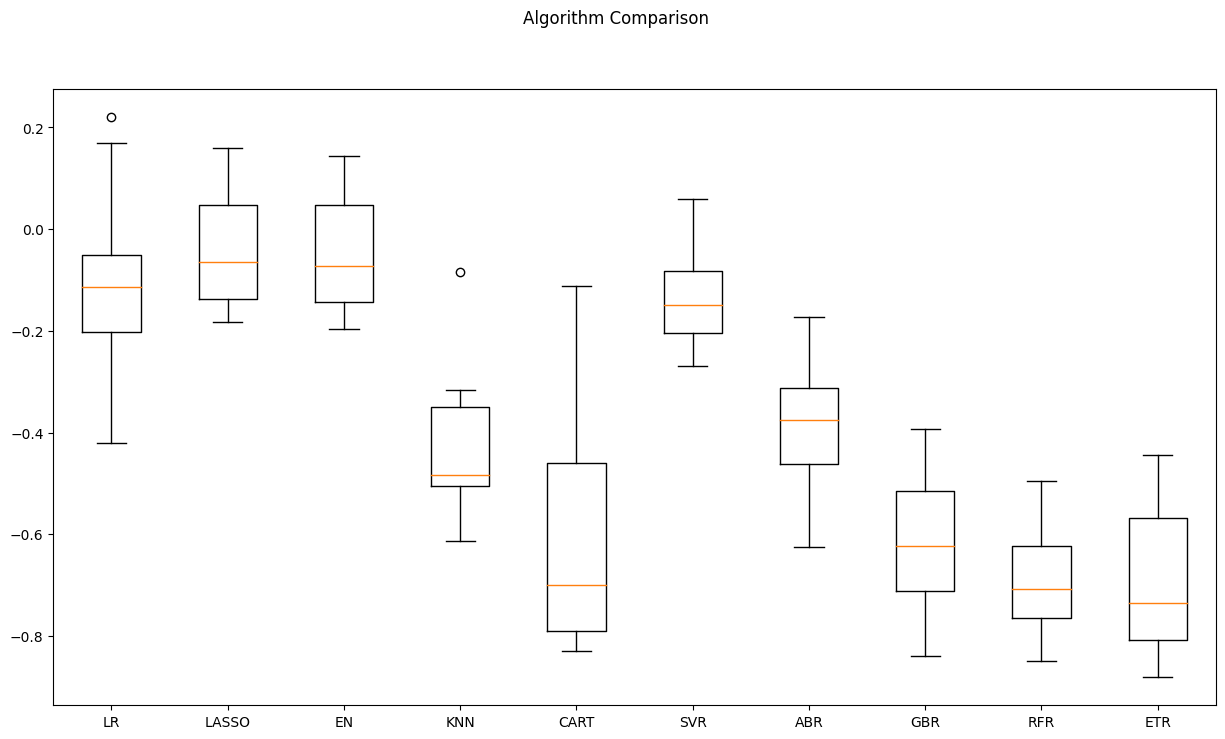

In [16]:
# Compare algorithms

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_kfold.kfold_results)
ax.set_xticklabels(results_kfold.names)
fig.set_size_inches(15, 8)
plt.show()


The non linear models perform better than the linear models, which means that a non linear relationship between the risk tolerance and the difference variables use to predict it. Given random forest regression is one of the best methods, we use it for further grid search. 

<a id='5'></a>
# 5. Model Tuning and Grid Search

Given that the Random Forest is the best model, Grid Search is performed on Random Forest.

In [17]:
params_grid_search = ParamsGridSearch(
    model=RandomForestRegressor(),
    params_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400]},
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=num_folds,
    scoring=scoring,
    seed=seed,
    shuffle=True,
)
grid_search_results = run_grid_search(params_grid_search)

Best: 0.715984 using {'n_estimators': 200}
0.713357 (0.089965) with: {'n_estimators': 50}
0.704056 (0.100578) with: {'n_estimators': 100}
0.711296 (0.107275) with: {'n_estimators': 150}
0.715984 (0.098665) with: {'n_estimators': 200}
0.715059 (0.109798) with: {'n_estimators': 250}
0.715072 (0.105818) with: {'n_estimators': 300}
0.706455 (0.093640) with: {'n_estimators': 350}
0.702689 (0.110314) with: {'n_estimators': 400}


<a id='6'></a>
# 6. Finalise the Model

Finalize Model with best parameters found during tuning step.

<a id='6.1'></a>
## 6.1. Results on the Test Dataset

In [18]:
# Prepare model

n_estimators = grid_search_results.best_params_['n_estimators']
model = RandomForestRegressor(n_estimators=n_estimators)
model.fit(X_train, Y_train)


RandomForestRegressor(n_estimators=200)

In [19]:
# Estimate accuracy on training set

Y_train_predicted = model.predict(X_train)
print('Training parameters: ')
print(f'R2: {r2_score(Y_train, Y_train_predicted)}')


Training parameters: 
R2: 0.9647082755197157


In [20]:
# Estimate accuracy on validation set

Y_test_predicted = model.predict(X_test)
print(f'Mean Square Error: {mean_squared_error(Y_test, Y_test_predicted)}')
print(f'R2: {r2_score(Y_test, Y_test_predicted)}')


Mean Square Error: 0.008136727890270479
R2: 0.7505704751158703


From the mean square error and R2 shown above for the test set, the results look good. 

<a id='6.2'></a>
## 6.2. Feature Importance and Features Intuition

Looking at the details above Random forest be worthy of further study.
Let us look into the Feature Importance of the RF model

[0.22836876 0.02416976 0.01386492 0.04397662 0.02263775 0.24209974
 0.05066334 0.37421911]


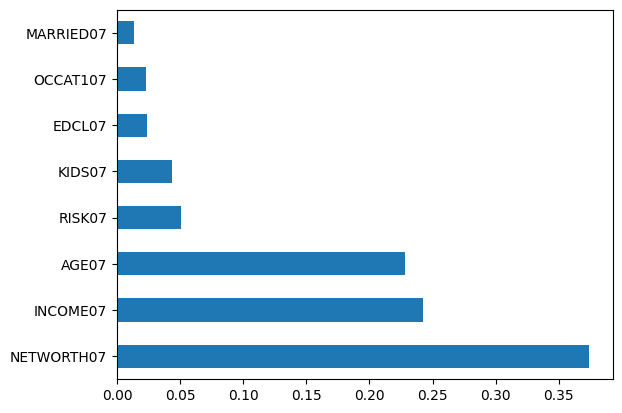

In [21]:
model = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)
model.fit(X_train, Y_train)
print(model.feature_importances_) # Use inbuilt class feature_importances of tree based classifiers

# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns).nlargest(10)
feat_importances.plot(kind='barh')

plt.show()


From the chart above, income and networth followed by age and willingness to take risk are the key variables to decide the risk tolerance. These variables have been considered as the key variables to model the risk tolerance across several literature. 

<a id='6.3'></a>
## 6.3. Save Model for Later Use

In [22]:
# Save the model to disk

filename = 'finalized_model.sav'
with open(filename, 'wb') as fh:
    dump(model, fh)

In [23]:
# Load the model from disk and estimate accuracy on validation set

with open(filename, 'rb') as fh:
    loaded_model = load(fh)

Y_test_predict = loaded_model.predict(X_test)
mse_loaded_model = mean_squared_error(Y_test, Y_test_predict)
r2_loaded_model = r2_score(Y_test, Y_test_predict)
print('Testing parameters from loaded model: ')
print(f'Mean Square Error: {mse_loaded_model}')
print(f'R2: {r2_loaded_model}')


Testing parameters from loaded model: 
Mean Square Error: 0.007196604318776838
R2: 0.7793897473014902


__Conclusion__:

We showed that machine learning models might be able to objectively
analyze the behavior of different investors in a changing market and attribute these
changes to variables involved in determining risk appetite. With an increase in the
volume of investor’s data and availability of rich machine learning infrastructure,
such models might prove to be more useful.

We saw that there is a non-linear relationship between the variables and the risk tolerance. Income and net worth followed by age and willingness to take risk are the key variables to decide the risk tolerance. These variables have been considered as the key variables to model the risk tolerance across several literature.
